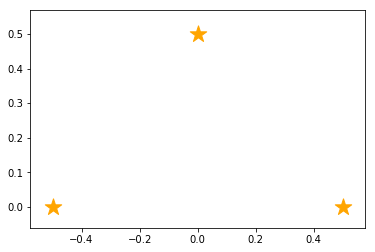

In [53]:
%matplotlib inline
import numpy as np
from copy import copy
import math, random
import matplotlib.pyplot as plt                   #   for plotting data
from matplotlib.patches import Ellipse      #  for drawing

        
actual_landmarks = [np.array([-0.5,0.0]),np.array([0.5,0.0]),np.array([0.0,0.5])]

def draw_landmarks(landmarks):
    xs = [ e[0] for e in landmarks]
    ys = [ e[1] for e in landmarks]
    plt.scatter(xs,ys,s=300,marker="*",label="landmarks",color="orange")
    
draw_landmarks(actual_landmarks)

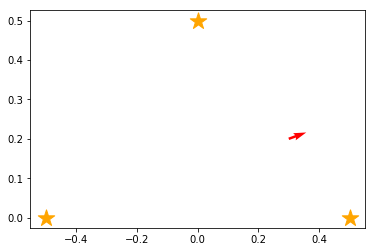

In [54]:
actual_x = np.array([0.3,0.2,math.pi*20.0/180])   #ロボットの実際の姿勢

def draw_robot(pose):
    plt.quiver([pose[0]],[pose[1]],[math.cos(pose[2])],[math.sin(pose[2])],color="red",label="actual robot motion")
    
draw_robot(actual_x)
draw_landmarks(actual_landmarks)

In [55]:
def relative_landmark_pos(pose,landmark):
    x,y,theta = pose
    lx,ly = landmark
    distance = math.sqrt((x -lx)**2 + (y-ly)**2)
    direction = math.atan2(ly-y, lx-x) - theta
    
    return (distance, direction,lx,ly) # 実際の位置も一緒に返す

In [56]:
measurements = [ relative_landmark_pos(actual_x,e) for e in actual_landmarks]
print(measurements)

[(0.8246211251235323, -3.2456798408617948, -0.5, 0.0), (0.28284271247461906, -1.1344640137963142, 0.5, 0.0), (0.4242640687119285, 2.0071286397934789, 0.0, 0.5)]


In [57]:
def draw_observation(pose,  measurement):
    x,y,theta = pose
    distance, direction,lx,ly = measurement
    lx = distance*math.cos(theta + direction) + x
    ly = distance*math.sin(theta + direction) + y
    plt.plot([pose[0],  lx],[pose[1],  ly],color="pink")
    
def draw_observations(pose,  measurements):
    for m in measurements:
        draw_observation(pose, m)

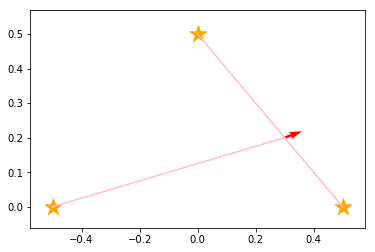

In [58]:
draw_landmarks(actual_landmarks)
draw_robot(actual_x)
draw_observations(actual_x,measurements)

In [59]:
def observation(pose, landmark):
    actual_distance,actual_direction,lx,ly = relative_landmark_pos(pose,landmark)
    # 方向の制限（cosの値が正）
    if (math.cos(actual_direction) < 0.0):
        return None
    
    measured_distance = random.gauss(actual_distance,actual_distance*0.1)  
    measured_direction = random.gauss(actual_direction,5.0/180.0*math.pi)  
    
    return (measured_distance, measured_direction,lx,ly)

def observations(pose,landmarks):
    return filter(lambda x: x != None, [ observation(pose,e) for e in landmarks])

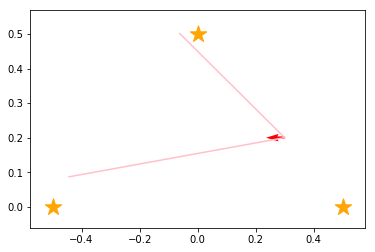

In [60]:
actual_x = np.array([0.3,0.2,math.pi*180.0/180])   #姿勢は変えること
measurements = observations(actual_x, actual_landmarks)

draw_landmarks(actual_landmarks)
draw_robot(actual_x)
draw_observations(actual_x, measurements)

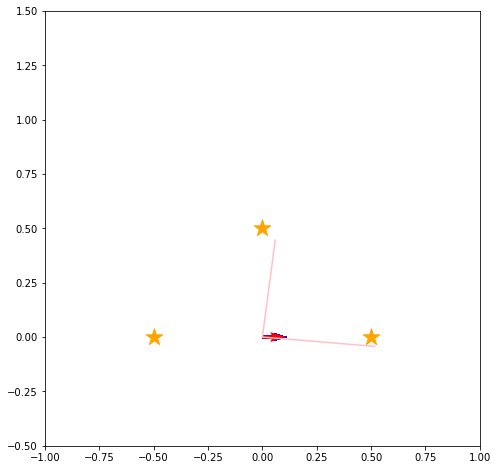

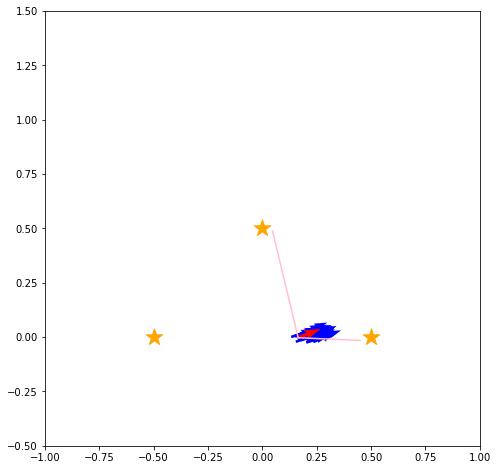

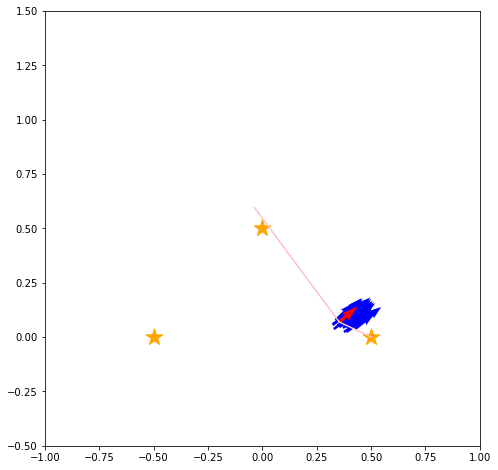

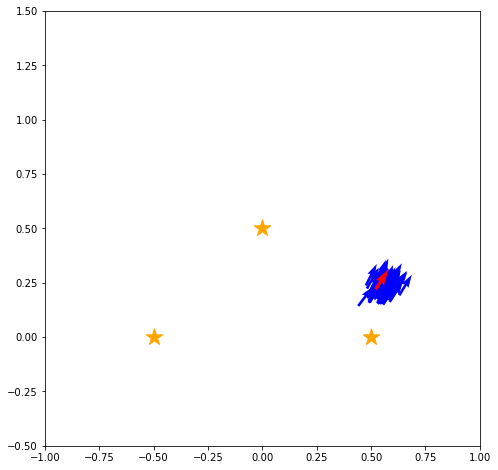

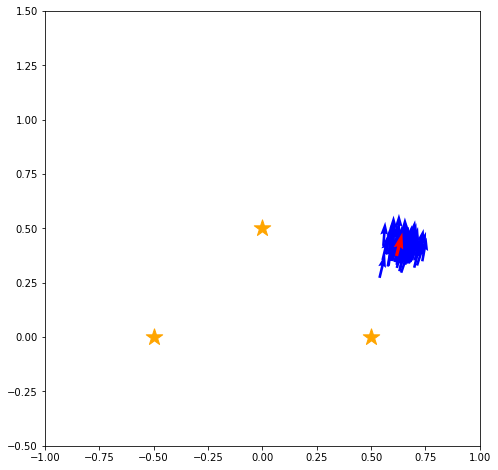

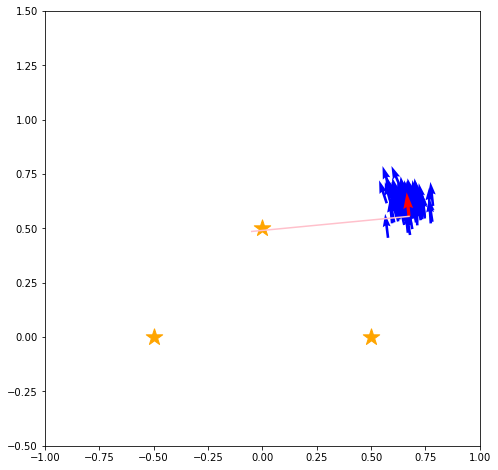

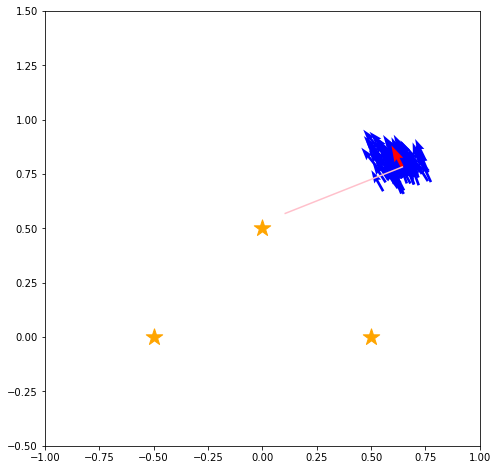

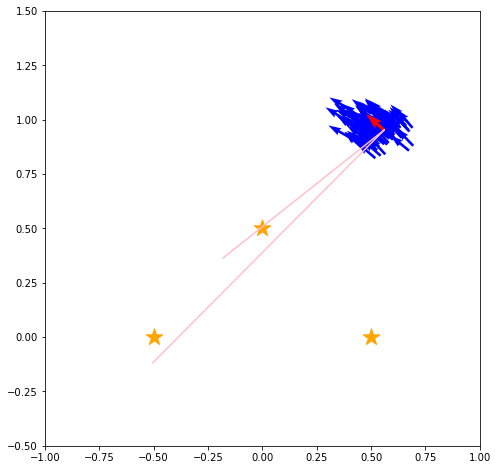

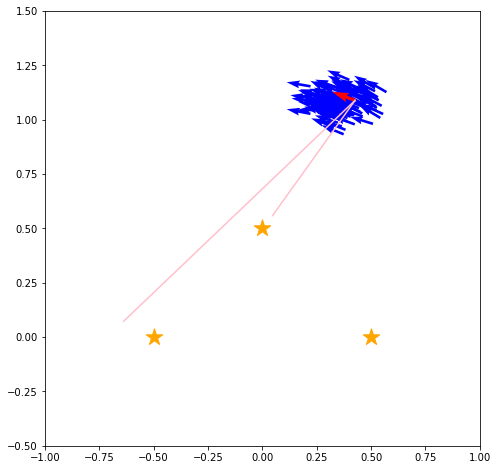

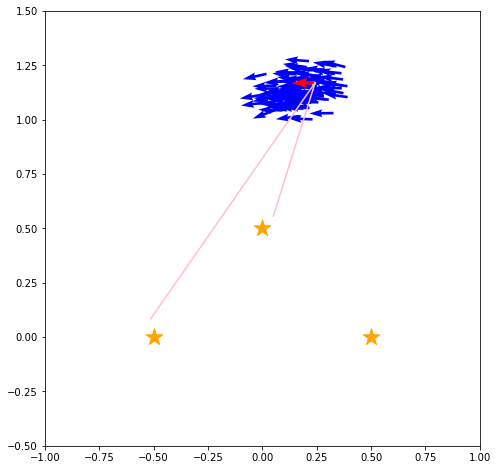

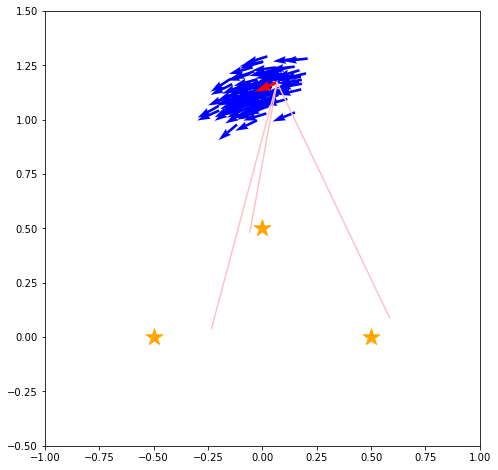

In [61]:
actual_x = np.array([0.0,0.0,0.0])   #ロボットの実際の姿勢
particles = [Particle(actual_x,1.0/100) for i in range(100)]
u = np.array([0.2,math.pi / 180.0 * 20]) #ロボットの移動

import copy

path = [actual_x]
particle_path = [copy.deepcopy(particles)]
measurementss = [observations(actual_x, actual_landmarks)]
for i in range(10):
    actual_x = f(actual_x,u)
    path.append(actual_x)
    measurementss.append(observations(actual_x,actual_landmarks))

    for p in particles:
        p.pose = f(p.pose,u)
    particle_path.append(copy.deepcopy(particles))

for i,p in enumerate(path):
    draw(path[i],particle_path[i])
    draw_landmarks(actual_landmarks)
    draw_observations(path[i],measurementss[i])

In [62]:
"""class Particle:
    def __init__(self,w):
        self.pose = np.array([0.0,0.0,0.0])
        self.weight = w
    
    def __repr__(self):
        return "pose: " + str(self.pose) + " weight: " + str(self.weight)
"""        

class Particle:
    def __init__(self,p,w ):  #姿勢も指定できるようにしましょう
        self.pose = np.array(p)
        self.weight = w
        
    def __repr__(self):
        return "pose: " + str(self.pose) + " weight: " + str(self.weight)

def f(x_old,u):
    pos_x, pos_y, pos_theta = x_old
    act_fw, act_rot = u
    
    act_fw = random.gauss(act_fw,act_fw/10)
    dir_error = random.gauss(0.0, math.pi / 180.0 * 3.0)
    act_rot = random.gauss(act_rot,act_rot/10)
    
    pos_x += act_fw * math.cos(pos_theta + dir_error)
    pos_y += act_fw * math.sin(pos_theta + dir_error)
    pos_theta += act_rot
    
    return np.array([pos_x,pos_y,pos_theta])

### 描画関数は少し変更を ###
def draw(pose,particles):    
    fig = plt.figure(i,figsize=(8, 8))
    sp = fig.add_subplot(111, aspect='equal')
    sp.set_xlim(-1.0,1.0)
    sp.set_ylim(-0.5,1.5)
    
    xs = [e.pose[0] for e in particles]
    ys = [e.pose[1] for e in particles]
    vxs = [math.cos(e.pose[2])*e.weight for e in particles]  #重みで長さを変えるようにしましょう
    vys = [math.sin(e.pose[2])*e.weight for e in particles]  #重みで長さを変えるようにしましょう
    plt.quiver(xs,ys,vxs,vys,color="blue",label="particles")
    
    plt.quiver([pose[0]],[pose[1]],[math.cos(pose[2])],[math.sin(pose[2])],color="red",label="actual robot motion")

In [63]:
from scipy.stats import norm  # ガウス分布（正規分布）のオブジェクトをインポート
def likelihood(pose, measurement):
    x,y,theta = pose
    distance, direction,lx,ly = measurement
    
    # パーティクルの姿勢から観測されるはずのランドマークの距離と向き
    rel_distance, rel_direction, tmp_x,tmp_y = relative_landmark_pos(pose,(lx,ly))

    # 誤差をガウスで評価
    return norm.pdf(x = distance - rel_distance, loc = 0.0, scale = rel_distance / 10.0)  \
             * norm.pdf(x = direction - rel_direction, loc = 0.0, scale = 5.0/180.0 * math.pi)
    
### パーティクル群の重みを変更する関数 ###
def change_weights(particles, measurement):
    for p in particles:
        p.weight *= likelihood(p.pose, measurement)
        
    # 重みの合計を1に保つ
    ws = [ p.weight for p in particles ]
    s = sum(ws)
    for p in particles: p.weight = p.weight / s

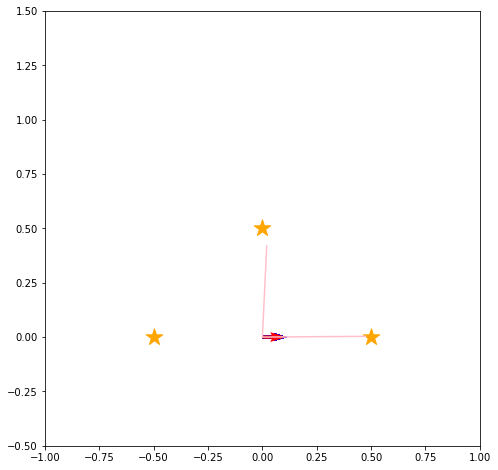

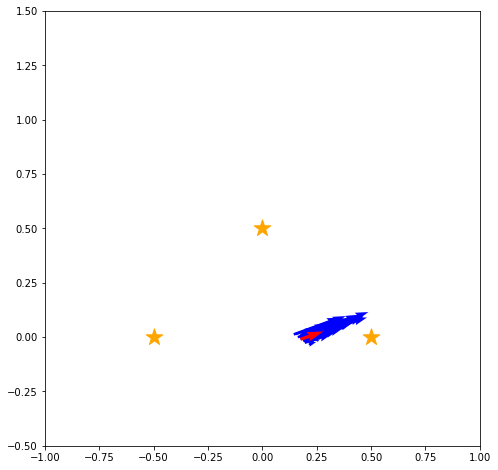

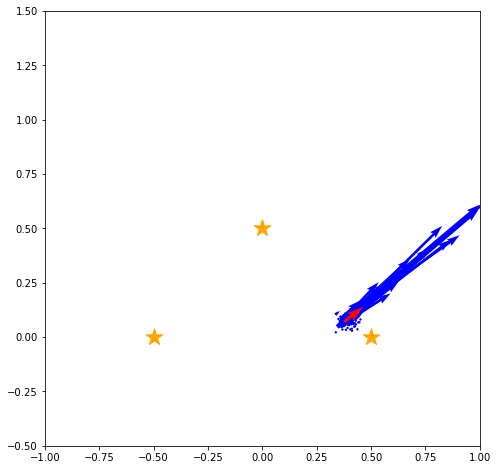

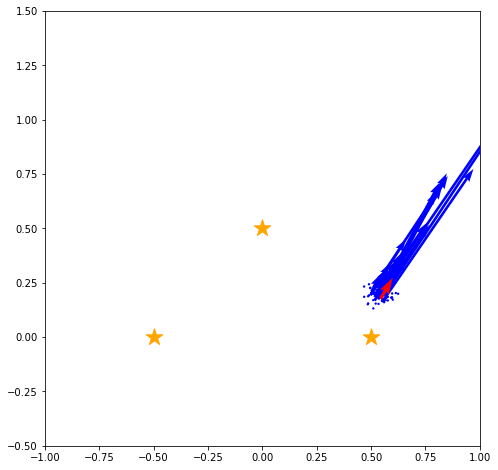

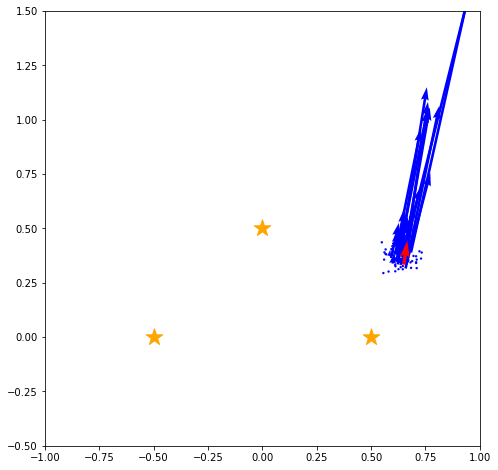

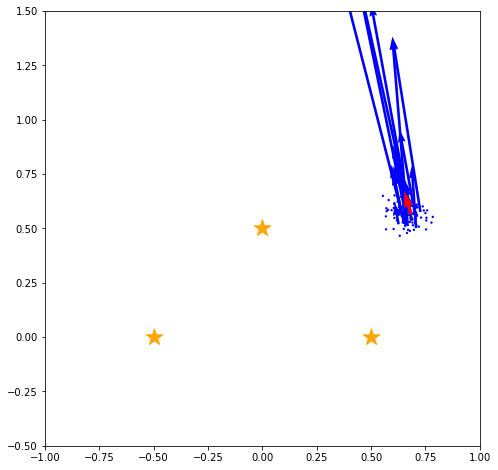

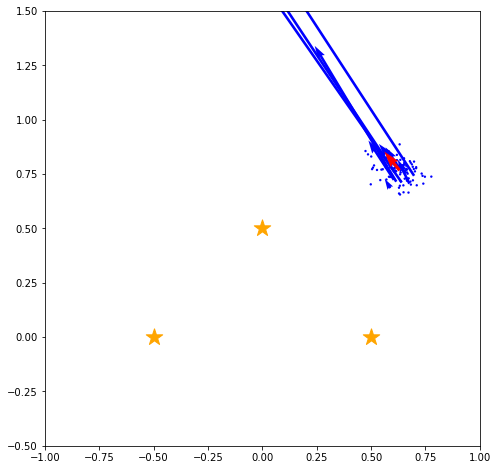

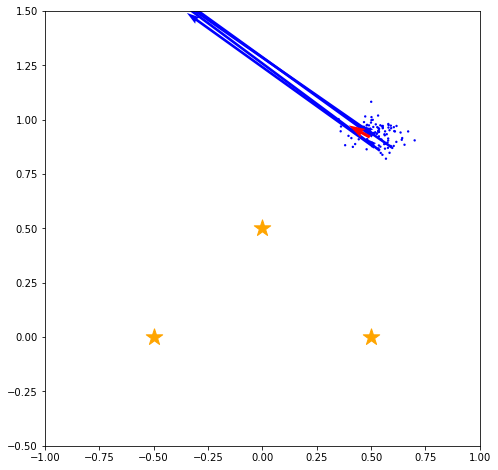

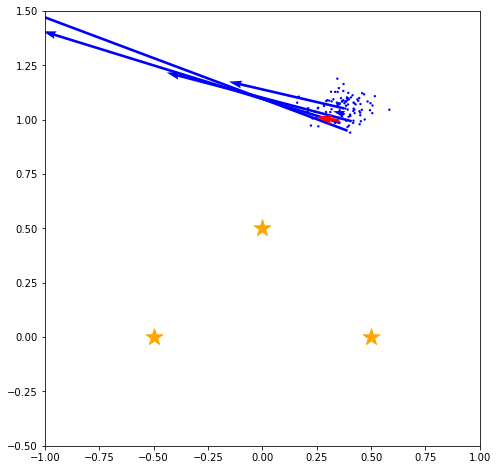

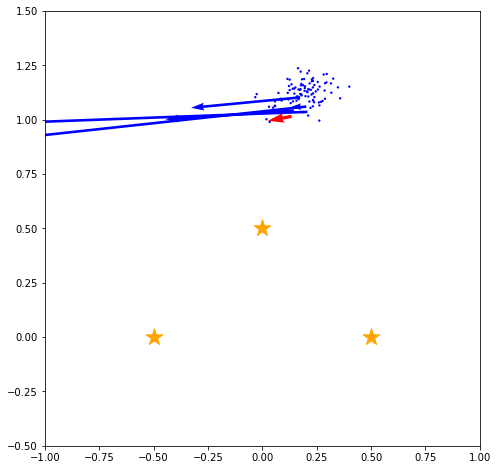

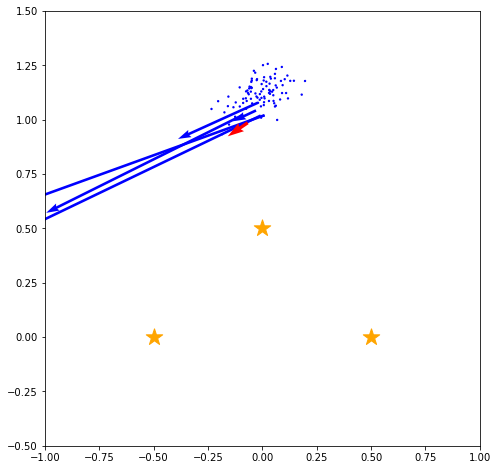

In [64]:
actual_x = np.array([0.0,0.0,0.0])   #ロボットの実際の姿勢
particles = [Particle(actual_x,1.0/100) for i in range(100)]
u = np.array([0.2,math.pi / 180.0 * 20]) #ロボットの移動

path = [actual_x]
particle_path = [copy.deepcopy(particles)]
measurementss = [observations(actual_x, actual_landmarks)]
for i in range(10):
    actual_x = f(actual_x,u)
    path.append(actual_x)
    ms = observations(actual_x,actual_landmarks)
    measurementss.append(ms)

    for p in particles:
        p.pose = f(p.pose,u)
    
    for m in ms:
        change_weights(particles, m)
    particle_path.append(copy.deepcopy(particles))

for i,p in enumerate(path):
    draw(path[i],particle_path[i])
    draw_landmarks(actual_landmarks)
    draw_observations(path[i],measurementss[i])

In [65]:
for p in particle_path[4]:
    print(p)

pose: [ 0.61122281  0.30248685  1.32839276] weight: 3.1325465305e-05
pose: [ 0.56688446  0.40321917  1.52209747] weight: 7.29790311935e-08
pose: [ 0.61575839  0.40713431  1.5407255 ] weight: 4.09739053145e-09
pose: [ 0.61682425  0.41043433  1.33314027] weight: 0.00514467969503
pose: [ 0.65982974  0.42830739  1.45904168] weight: 4.43893679487e-05
pose: [ 0.64894875  0.43742785  1.526189  ] weight: 0.00868685103725
pose: [ 0.6309762   0.38548686  1.39999179] weight: 0.00880307582508
pose: [ 0.61098071  0.39456576  1.40627216] weight: 0.000560486308088
pose: [ 0.59760345  0.41792361  1.48657239] weight: 0.000502756021806
pose: [ 0.58295728  0.37246358  1.38536976] weight: 0.00276079682858
pose: [ 0.54928798  0.43576806  1.51620908] weight: 3.37552378446e-07
pose: [ 0.68372743  0.31830452  1.27248998] weight: 0.000109329461301
pose: [ 0.6591961   0.38918105  1.39834241] weight: 0.000434935604451
pose: [ 0.6487117   0.34638253  1.39861119] weight: 0.00245988004105
pose: [ 0.61167434  0.3811

In [66]:
accum = []
sm = 0.0
for p in particles:
    accum.append(p.weight + sm)
    sm += p.weight
    
print(accum)

[0.0, 1.27927980603041e-08, 1.2802572453226513e-08, 1.2802572961681186e-08, 2.3217305758229427e-07, 2.3261843695524365e-07, 2.3266507042932663e-07, 2.3266507204573662e-07, 2.3266507204575293e-07, 2.3428992771035393e-07, 2.3428992813160104e-07, 2.3443205405880061e-07, 2.3790729423006423e-07, 2.3790729423012172e-07, 2.3790729426301127e-07, 2.3790729490443589e-07, 2.6334158940620489e-07, 2.6334158940620515e-07, 2.6334192971111998e-07, 2.6334192971111998e-07, 2.6334192971117848e-07, 2.633627085452012e-07, 2.6336273196249445e-07, 0.00031437373312590054, 0.00031437373312590054, 0.00031437373312590054, 0.00031437373312590054, 0.00031437373315510066, 0.00031437373315510066, 0.00031437373315510066, 0.00031437373315510066, 0.00031446470526705041, 0.00031446470526706098, 0.00031446473861480916, 0.00031446473861480926, 0.010852818823670164, 0.010852818823670164, 0.010852818823670164, 0.010852818823670164, 0.01085301156249224, 0.010853011942226015, 0.010853011942226015, 0.010853272216686416, 0.0108

In [67]:
pointer = random.uniform(0.0,1.0/len(particles))
print(pointer)

0.00840736423028482


In [68]:
new_particles = []
particles_num = len(particles)

while pointer < 1.0:
    if accum[0] >= pointer:
        new_particles.append(Particle(copy.deepcopy(particles[0].pose),1.0/particles_num))
        
        pointer += 1.0/particles_num
    else:
        accum.pop(0)
        particles.pop(0)

In [69]:
particles = new_particles

for p in particles:
    print(p)

pose: [-0.02931546  1.04218159  3.57987976] weight: 0.01
pose: [-0.08709302  1.02291431  3.6033306 ] weight: 0.01
pose: [-0.08709302  1.02291431  3.6033306 ] weight: 0.01
pose: [-0.08709302  1.02291431  3.6033306 ] weight: 0.01
pose: [-0.08709302  1.02291431  3.6033306 ] weight: 0.01
pose: [-0.08709302  1.02291431  3.6033306 ] weight: 0.01
pose: [-0.08709302  1.02291431  3.6033306 ] weight: 0.01
pose: [-0.08709302  1.02291431  3.6033306 ] weight: 0.01
pose: [-0.08709302  1.02291431  3.6033306 ] weight: 0.01
pose: [-0.08709302  1.02291431  3.6033306 ] weight: 0.01
pose: [-0.00767748  1.01859845  3.58914239] weight: 0.01
pose: [-0.00767748  1.01859845  3.58914239] weight: 0.01
pose: [-0.00767748  1.01859845  3.58914239] weight: 0.01
pose: [-0.00767748  1.01859845  3.58914239] weight: 0.01
pose: [-0.00767748  1.01859845  3.58914239] weight: 0.01
pose: [-0.00767748  1.01859845  3.58914239] weight: 0.01
pose: [-0.00767748  1.01859845  3.58914239] weight: 0.01
pose: [-0.00767748  1.01859845 

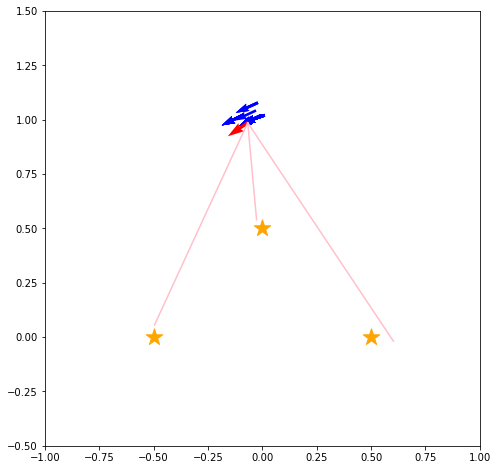

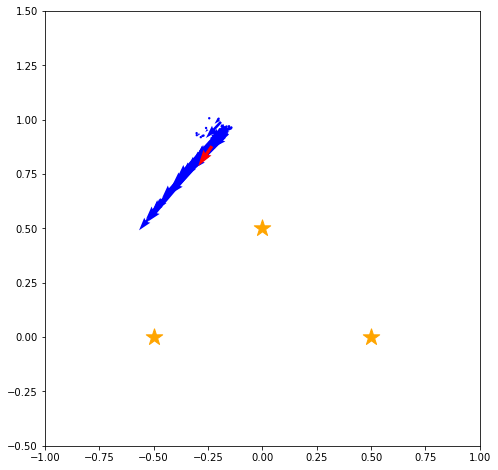

In [70]:
#actual_x = np.array([0.0,0.0,0.0])   #ロボットの実際の姿勢
#particles = [Particle(actual_x,1.0/100) for i in range(100)]
#u = np.array([0.2,math.pi / 180.0 * 20]) #ロボットの移動

path = [actual_x]
particle_path = [copy.deepcopy(particles)]
measurementss = [observations(actual_x, actual_landmarks)]
for i in range(1):
    actual_x = f(actual_x,u)
    path.append(actual_x)
    ms = observations(actual_x,actual_landmarks)
    measurementss.append(ms)

    for p in particles:
        p.pose = f(p.pose,u)
    
    for m in ms:
        change_weights(particles, m)
    particle_path.append(copy.deepcopy(particles))

for i,p in enumerate(path):
    draw(path[i],particle_path[i])
    draw_landmarks(actual_landmarks)
    draw_observations(path[i],measurementss[i])

In [78]:
できてそう = 0

In [79]:
できてそう

0